# Imports

In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt
plt.switch_backend('agg')

import pandas as pd
import re
import time
import torch
import torch.nn as nn
import torch.optim as optim

from PIL import Image
from sklearn.metrics import accuracy_score, cohen_kappa_score
from torch.utils.data import Dataset, DataLoader, Sampler
from torchvision import transforms, models
from tqdm import tqdm
from densenet import densenet169

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
cpu = torch.device('cpu')

# Looking at Data

In [4]:
!ls MURA-v1.1/

train		       train_labeled_studies.csv  valid_image_paths.csv
train_image_paths.csv  valid			  valid_labeled_studies.csv


In [5]:
train_labled_studies = pd.read_csv('MURA-v1.1/valid_image_paths.csv', header=None)
train_labled_studies.head()

,0
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...
1,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...
2,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...
3,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...
4,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...


In [6]:
train_labled_studies.loc[0].iloc[0]

'MURA-v1.1/valid/XR_WRIST/patient11185/study1_positive/image1.png'

In [7]:
class MuraDatasetByStudy(Dataset):
    def __init__(self, csv_file, transform):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            transform (callable): Transform to be applied on a sample.
        """
        
        df = pd.read_csv(csv_file, header=None)
        self.study_pths = df.iloc[:,0]
        self.labels = df.iloc[:, 1]
        self.transform = transform

    def __len__(self):
        return len(self.study_pths)
    
    def __getitem__(self, idx):
        study_path = self.study_pths[idx]
        
        # get images for this study
        i = 0
        images = []
        while(True):
            img_name = study_path + 'image%s.png' % (i+1)
            try:
                img = Image.open(img_name)
                img = img.convert('RGB')
                images.append(self.transform(img))
                i += 1
            except FileNotFoundError:
                break
        
        images = torch.stack(images)
        label = self.labels[idx]
        
        m = re.match(r'.*/XR_(\w*)/patient(\d+)/study(\d+)_', img_name)
        study_type = m.group(1)
        study_id = m.group(2)+'/'+m.group(3)
        
        return images, study_type, study_id, label
    
    def __iter__(self):
        self.idx = 0
        return self
    
    def __next__(self):
        if self.idx >= len(self):
            raise StopIteration
        
        result = self[self.idx]
        self.idx += 1
        return result

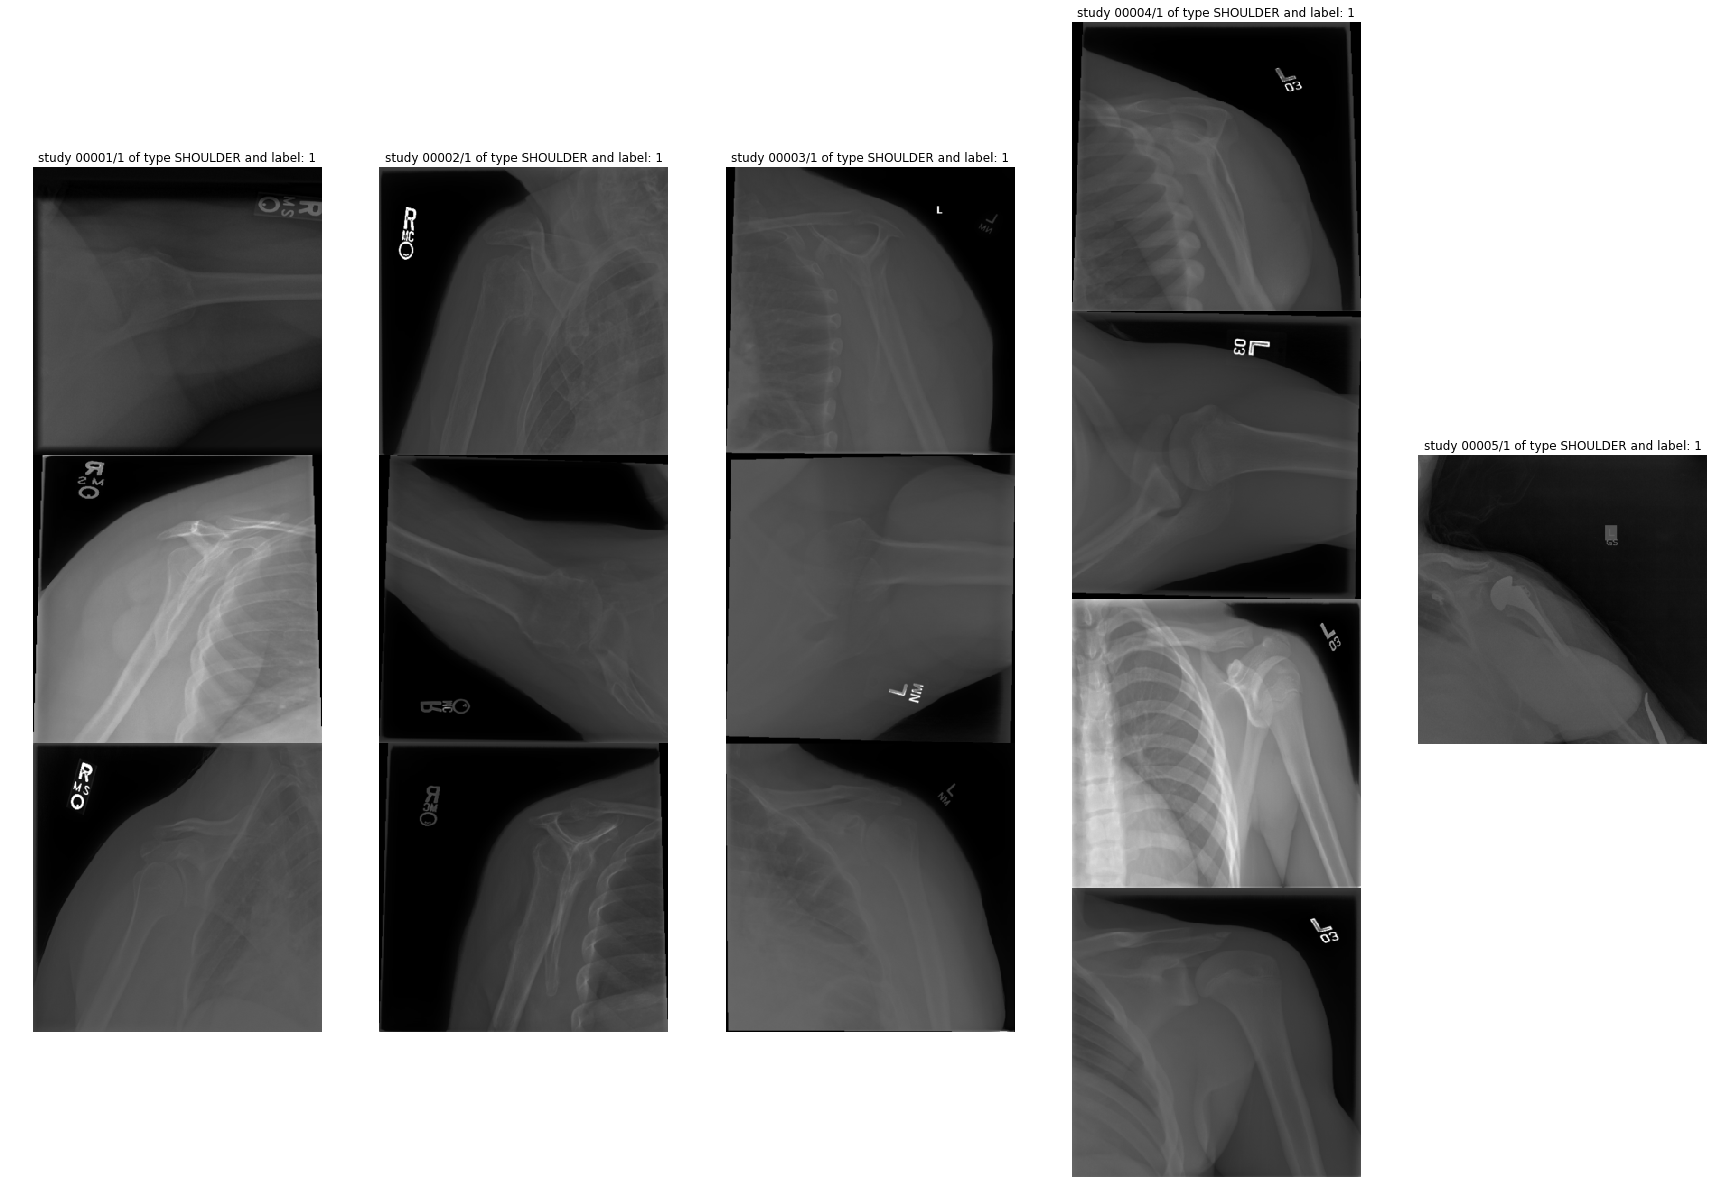

In [8]:
%matplotlib inline

fig = plt.figure(figsize=(30, 120))
i = 0

transform = transforms.Compose([
        transforms.Resize((320, 320)),
        transforms.ToTensor(),
#         transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])

pilTrans = transforms.ToPILImage()

# for img, img_type, label, patient, study in MuraDataset(csv_file='MURA-v1.1/train_image_paths.csv'):
for imgs, study_type, study_id, label in MuraDatasetByStudy('MURA-v1.1/train_labeled_studies.csv', transform):
    ax = plt.subplot(1, 5, i+1)
    ax.set_title("study %s of type %s and label: %i" % (study_id, study_type, label))
    ax.axis('off')
    plt.imshow(pilTrans(np.transpose(imgs, (1, 0, 2, 3)).reshape((3, -1, 320))))
    i += 1
    if i > 4:
        plt.show()
        break

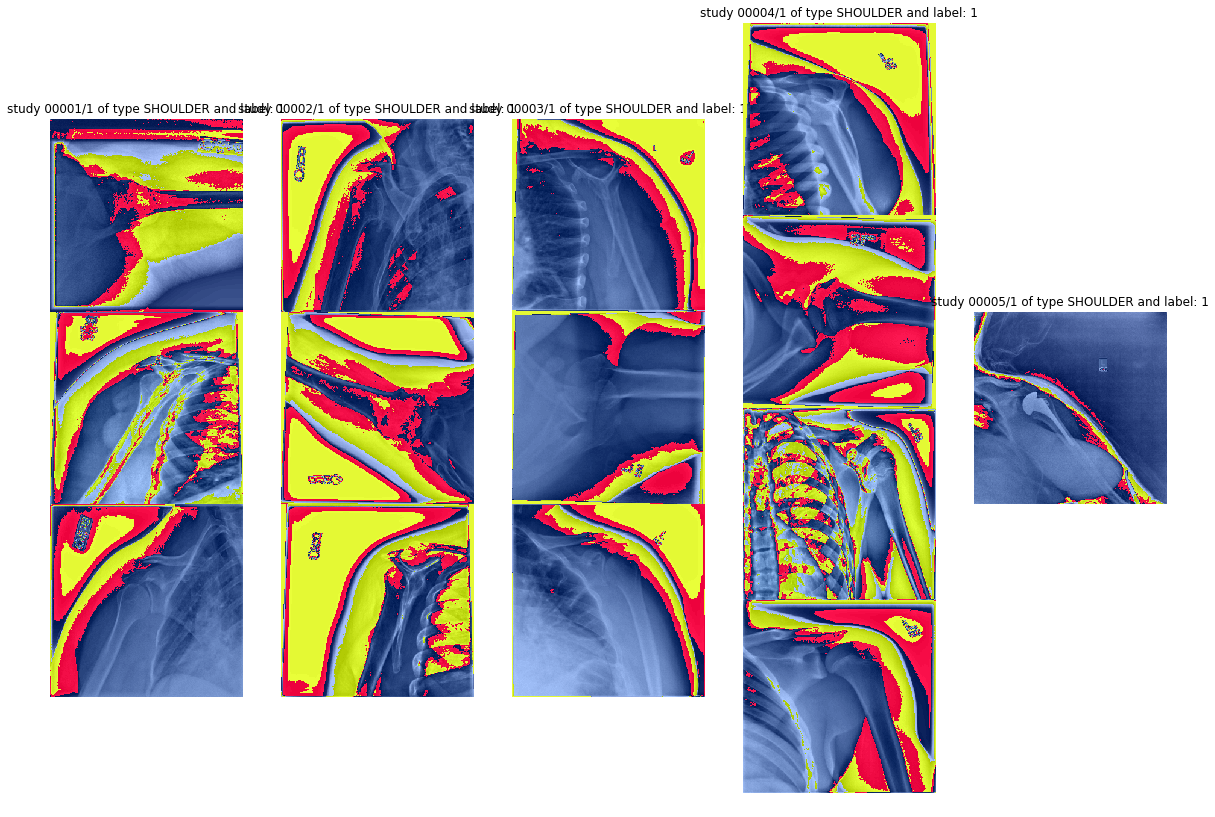

In [9]:
%matplotlib inline

fig = plt.figure(figsize=(20, 120))
i = 0

transform = transforms.Compose([
        transforms.Resize((320, 320)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])

pilTrans = transforms.ToPILImage()

# for img, img_type, label, patient, study in MuraDataset(csv_file='MURA-v1.1/train_image_paths.csv'):
for imgs, study_type, study_id, label in MuraDatasetByStudy('MURA-v1.1/train_labeled_studies.csv', transform):
    ax = plt.subplot(1, 5, i+1)
    ax.set_title("study %s of type %s and label: %i" % (study_id, study_type, label))
    ax.axis('off')
    plt.imshow(pilTrans(np.transpose(imgs, (1, 0, 2, 3)).reshape((3, -1, 320))))
    i += 1
    if i > 4:
        plt.show()
        break

In [10]:
class MuraDataset(Dataset):
    def __init__(self, csv_file, transform, augment_transforms=[]):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        traindf = pd.read_csv(csv_file, header=None)
        self.train_img_pths = traindf.iloc[:,0]
        self.transform = transform
        self.augment_transforms = augment_transforms

    def __len__(self):
        return (len(self.augment_transforms)+1)*len(self.train_img_pths)
    
    def __getitem__(self, idx):
        if idx >= len(self.train_img_pths):
            idx = idx%len(self.train_img_pths)
            transform = self.augment_transforms[idx//len(self.train_img_pths)-0]
        else:
            transform = self.transform

        img_name = self.train_img_pths[idx]
        img = Image.open(img_name)
        img = img.convert('RGB')
        img = transform(img)
        
        img_study_type = re.match(r'.*/XR_(\w*)/', img_name).group(1)
        img_label = int(
            re.match(r'.*/study\d+_(\w+)/', img_name).group(1) == 'positive'
        )
        img_study_name = re.match(r'(.*/).*png', img_name).group(1)
        
        return img, img_study_name, img_study_type, img_label
    
    def __iter__(self):
        self.idx = 0
        return self
    
    def __next__(self):
        if self.idx >= len(self):
            raise StopIteration
        
        result = self[self.idx]
        self.idx += 1
        return result

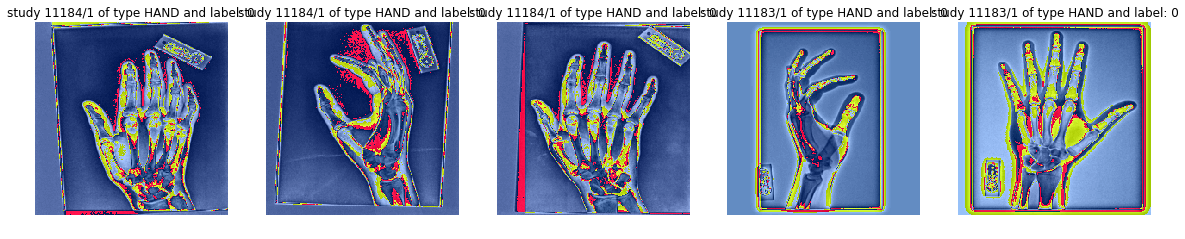

In [11]:
%matplotlib inline

fig = plt.figure(figsize=(20, 80))
i = 0

transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])

augment_transforms = [
    transforms.Compose([
#         transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])
]

pilTrans = transforms.ToPILImage()

# for img, img_type, label, patient, study in MuraDataset(csv_file='MURA-v1.1/train_image_paths.csv'):
for img, study_name, study_type, label in reversed(
    MuraDataset('MURA-v1.1/train_image_paths.csv', transform)
):
    ax = plt.subplot(1, 5, i+1)

    img_study = re.match(r'.*/study(\d)_\w+', study_name).group(1)
    img_patient = re.match(r'.*/patient(\d+)/', study_name).group(1)
    study_id = img_patient+'/'+img_study
    
    ax.set_title("study %s of type %s and label: %i" % (study_id, study_type, label))
    ax.axis('off')
    plt.imshow(pilTrans(img))
    i += 1
    if i > 4:
        plt.show()
        break

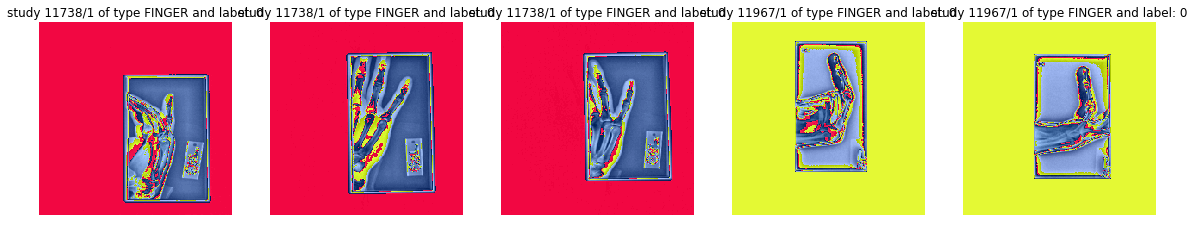

In [12]:
%matplotlib inline

fig = plt.figure(figsize=(20, 80))
i = 0

transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])

pilTrans = transforms.ToPILImage()

# for img, img_type, label, patient, study in MuraDataset(csv_file='MURA-v1.1/train_image_paths.csv'):
for img, study_name, study_type, label in reversed(MuraDataset('MURA-v1.1/valid_image_paths.csv', transform)):
    ax = plt.subplot(1, 5, i+1)

    img_study = re.match(r'.*/study(\d)_\w+', study_name).group(1)
    img_patient = re.match(r'.*/patient(\d+)/', study_name).group(1)
    study_id = img_patient+'/'+img_study
    
    ax.set_title("study %s of type %s and label: %i" % (study_id, study_type, label))
    ax.axis('off')
    plt.imshow(pilTrans(img))
    i += 1
    if i > 4:
        plt.show()
        break

# Custom Loss Function

In [13]:
# %%time
# dataset = MuraDataset(
#     csv_file='MURA-v1.1/train_image_paths.csv',
#     transform=data_transforms['train'],
# )

# df = pd.DataFrame({
#     'study_type': [study_type for _, _, study_type, _ in dataset],
#     'label': [label for _, _, _, label in dataset]
# })

In [14]:
# df_positives = df[df.label == 1]
# df_negatives = df[df.label == 0]

In [15]:
# df_positive_nums = df_positives.groupby('study_type').agg({'label': 'count'})
# df_negative_nums = df_negatives.groupby('study_type').agg({'label': 'count'})
# df_nums = df_positive_nums.join(df_negative_nums, lsuffix='_positive', rsuffix='_negative')

In [16]:
# df_nums.to_csv('study_counts.csv', index=False)

In [17]:
study_counts = pd.read_csv('study_counts.csv')
study_counts = study_counts.set_index('study_type')

In [18]:
def weights(study_type):
    Nt = study_counts.loc[study_type].loc['label_positive']
    At = study_counts.loc[study_type].loc['label_negative']
    return At/(At+Nt), Nt/(At+Nt), 

In [19]:
Wt = {t : weights(t) for t in study_counts.index}
Wt

{'ELBOW': (0.593185966335429, 0.4068140336645711),
 'FINGER': (0.6145710928319624, 0.3854289071680376),
 'FOREARM': (0.6378082191780822, 0.36219178082191783),
 'HAND': (0.7322749413674905, 0.26772505863250945),
 'HUMERUS': (0.5290880503144654, 0.47091194968553457),
 'SHOULDER': (0.5025659386561642, 0.4974340613438358),
 'WRIST': (0.591160787530763, 0.4088392124692371)}

In [20]:
class WeightedCrossEntropyLoss(torch.nn.modules.Module):
    def __init__(self, W, cpu=False):
        super(WeightedCrossEntropyLoss, self).__init__()
        self.W = W
        self.T = torch.DoubleTensor if cpu else torch.cuda.DoubleTensor
    
    def forward(self, inputs, targets, keys):
        Wt1 = self.T([self.W[key][1] for key in keys])
        Wt0 = self.T([self.W[key][0] for key in keys])
        targets = targets.double()
        inputs = inputs.double()
        loss = - (Wt1*targets*inputs.log() + Wt0*(1-targets)*(1-inputs).log())
        
        return loss

In [21]:
del study_counts

# Model

In [22]:
batch_size = 8

# Setup the loss fxn
criterion = WeightedCrossEntropyLoss(Wt)
cpu_criterion = WeightedCrossEntropyLoss(Wt, cpu=True)


model = densenet169(pretrained=False, drop_rate=0.2)
# freeze everything to extract feature vector
# for param in model.parameters():
#     param.requires_grad = False

# introduce linear layer whose parameter we want to modify
model.fc = nn.Linear(model.fc.in_features, 1)


optimizer = optim.Adam(model.parameters(), lr=0.0001)
input_size = 224

/home/youssefe_fares/densenet.py:113: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [23]:
data_transforms = {
        'train': transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]),
        'valid': transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]),
    }

augment_transforms = [
    transforms.Compose([
        transforms.CenterCrop((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
]


datasets_dict = {
    x: MuraDataset(
        csv_file='MURA-v1.1/%s_image_paths.csv' % x,
        transform=data_transforms[x],
        augment_transforms=augment_transforms if x == 'train' else [],
    ) for x in ['train', 'valid']
}

# # subset
# dataloaders_dict = {
#     x: DataLoader(
#         torch.utils.data.Subset(
#             dataset=datasets_dict[x],
#             indices=np.random.randint(
#                 len(datasets_dict[x]),
#                 size=100,
#             ),
#         ),
#         batch_size=batch_size,
#         num_workers=8,
#     ) for x in ['train', 'valid']
# }

dataloaders_dict = {
    x: DataLoader(
        datasets_dict[x],
        shuffle=True,
        batch_size=batch_size,
        num_workers=8,
    ) for x in ['train', 'valid']
}

In [24]:
def update_learning_rate(optimizer, update):
    for param_group in optimizer.param_groups:
        param_group['lr'] = update(param_group['lr'])
    print('learning rate decreased to %f', optimizer.param_groups[0]['lr'])

In [25]:
def train_model(model, train_loader, criterion, optimizer, epoch_n=10, validation_loader=None):
    model = model.to(device)
    model.train()
    last_valid_acc = 0
    best_models = [] # Stores tuples (validation_acc, model state dict)
    
    for epoch in range(epoch_n):
        print('=========================epoch %i=====================' % epoch)
        epoch_loss = 0.0
        running_loss = 0.0
        epoch_corrects = 0
        for i, data in enumerate(tqdm(train_loader)):
            inputs, _, study_type, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            outputs = torch.mean(outputs, 1)
            loss = criterion(outputs, labels, study_type)
            
            loss.sum().backward()
            optimizer.step()
            preds = (outputs > 0.5).type(torch.cuda.LongTensor)
            epoch_corrects += torch.sum(preds == labels.data)
            
            # print statistics
            running_loss += loss.sum()
            epoch_loss += loss.sum()
        
        epoch_loss = epoch_loss / len(train_loader.dataset)
        epoch_accuracy = epoch_corrects.double() / len(train_loader.dataset)
        print('epoch loss: %.8f' % epoch_loss)
        print('epoch accuracy: %.8f' % epoch_accuracy)
        
        # if no validation set, keep training
        if not validation_loader:
            continue
        
        # else evaluate first then keep training
        _, valid_loss, valid_acc, valid_kappa = validate_model(
            [model],
            validation_loader,
            criterion,
            optimizer,
        )
        print('epoch valid_loss: %8f' % valid_loss)
        print('epoch valid_acc: %.8f' % valid_acc)
        print('last epoch valid_acc: %.8f' % last_valid_acc)
        print('epoch valid_kappa: %.8f' % valid_kappa)

        if abs(valid_acc - last_valid_acc) < 0.0001:
            update_learning_rate(optimizer, update= lambda x: 0.1*x)
        last_valid_acc = valid_acc
        
        # maintain top 5 models
        model_tuple = (valid_acc, model.state_dict())
        if len(best_models) < 5:
            best_models.append(model_tuple)
        else:
            best_models = sorted(best_models, key=lambda x: x[0])
            best_models[0] = model_tuple
            
    return model if not validation_loader else best_models

In [26]:
def validate_model(models, validation_loader, criterion, optimizer):
    """
    returns (df, acc, kappa)
        df: Pandas dataframe containing study paths and their corresponding label
        obtained by averaging the model scores on the study's images and treating any
        score higher than 0.5 as abnormal.
        
        acc: model accuracy score on studies
        kappa: model kappa score on studies
    """
    for model in models:
        model = model.to(device)
        model.eval()
    total_loss = 0.0
    
    all_study_names = []
    all_outputs = []
    
    for i, data in enumerate(tqdm(validation_loader)):
        inputs, study_names, study_types, labels = data
        all_study_names += study_names
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        
        with torch.set_grad_enabled(False):
            ensembled_outputs = []
            for model in models:
                outputs = model(inputs)
                outputs = torch.mean(outputs, 1)
                ensembled_outputs.append(outputs)
            outputs = torch.stack(ensembled_outputs)
            outputs = torch.mean(outputs, 0)
            all_outputs += outputs.tolist()
            loss = criterion(outputs, labels, study_types)
        
        total_loss += loss.sum()
    
    total_loss /= len(validation_loader.dataset)
    results_df = pd.DataFrame({
        'study': all_study_names,
        'prob': all_outputs,
    })
    
    predicted_labeled_studies = results_df.groupby('study').agg({'prob': 'mean'})
    predicted_labeled_studies = predicted_labeled_studies.reset_index()
    
    predicted_labeled_studies['prediction'] = (predicted_labeled_studies['prob'] > 0.5).astype('int8')
    
    valid_labeled_studies = pd.read_csv(
        'MURA-v1.1/valid_labeled_studies.csv',
        header=None,
        names= ['study', 'label']
    )
    
   
    joined_df = predicted_labeled_studies.join(valid_labeled_studies.set_index('study'), on='study')
    
    
    accuracy = accuracy_score(joined_df.label, joined_df.prediction)
    kappa = cohen_kappa_score(joined_df.label, joined_df.prediction)
    
    return joined_df, total_loss.item(), accuracy, kappa

In [27]:
best_models = train_model(model, dataloaders_dict['train'], criterion, optimizer, 10, dataloaders_dict['valid'])

  0%|          | 0/9202 [00:00<?, ?it/s]

=========================epoch 0=====================


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
  0%|          | 0/400 [00:00<?, ?it/s]

epoch loss: 0.30876220
epoch accuracy: 0.63415562


  0%|          | 0/9202 [00:00<?, ?it/s]

epoch valid_loss: 0.290493
epoch valid_acc: 0.69307756
last epoch valid_acc: 0.00000000
epoch valid_kappa: 0.35346265
=========================epoch 1=====================


  0%|          | 0/400 [00:00<?, ?it/s]

epoch loss: 0.28312917
epoch accuracy: 0.68703814


  0%|          | 0/9202 [00:00<?, ?it/s]

epoch valid_loss: 0.278981
epoch valid_acc: 0.70141785
last epoch valid_acc: 0.69307756
epoch valid_kappa: 0.36206343
=========================epoch 2=====================


  0%|          | 0/400 [00:00<?, ?it/s]

epoch loss: 0.26749226
epoch accuracy: 0.71098674


  0%|          | 0/9202 [00:00<?, ?it/s]

epoch valid_loss: 0.277481
epoch valid_acc: 0.71142619
last epoch valid_acc: 0.70141785
epoch valid_kappa: 0.38747771
=========================epoch 3=====================


  0%|          | 0/400 [00:00<?, ?it/s]

epoch loss: 0.25971692
epoch accuracy: 0.72311726


100%|██████████| 400/400 [00:55<00:00,  7.25it/s]


epoch valid_loss: 0.292359
epoch valid_acc: 0.66472060
last epoch valid_acc: 0.71142619
epoch valid_kappa: 0.27464123
=========================epoch 4=====================


  0%|          | 0/400 [00:00<?, ?it/s]

epoch loss: 0.25326308
epoch accuracy: 0.73227288


  0%|          | 0/9202 [00:00<?, ?it/s]

epoch valid_loss: 0.295829
epoch valid_acc: 0.68807339
last epoch valid_acc: 0.66472060
epoch valid_kappa: 0.32987731
=========================epoch 5=====================


  0%|          | 0/400 [00:00<?, ?it/s]

epoch loss: 0.24778582
epoch accuracy: 0.74062704


  0%|          | 0/9202 [00:00<?, ?it/s]

epoch valid_loss: 0.254275
epoch valid_acc: 0.75396163
last epoch valid_acc: 0.68807339
epoch valid_kappa: 0.48514931
=========================epoch 6=====================


  0%|          | 0/400 [00:00<?, ?it/s]

epoch loss: 0.24258394
epoch accuracy: 0.74701152


100%|██████████| 400/400 [00:54<00:00,  7.29it/s]


epoch valid_loss: 0.257223
epoch valid_acc: 0.74061718
last epoch valid_acc: 0.75396163
epoch valid_kappa: 0.45429414
=========================epoch 7=====================


  0%|          | 0/400 [00:00<?, ?it/s]

epoch loss: 0.23768561
epoch accuracy: 0.75441480


  0%|          | 0/9202 [00:00<?, ?it/s]

epoch valid_loss: 0.248219
epoch valid_acc: 0.75229358
last epoch valid_acc: 0.74061718
epoch valid_kappa: 0.47848418
=========================epoch 8=====================


  0%|          | 0/400 [00:00<?, ?it/s]

epoch loss: 0.23209516
epoch accuracy: 0.76226636


  0%|          | 0/9202 [00:00<?, ?it/s]

epoch valid_loss: 0.252261
epoch valid_acc: 0.75396163
last epoch valid_acc: 0.75229358
epoch valid_kappa: 0.48422588
=========================epoch 9=====================


  0%|          | 0/400 [00:00<?, ?it/s]

epoch loss: 0.22742862
epoch accuracy: 0.76983265


100%|██████████| 400/400 [00:53<00:00,  7.42it/s]

epoch valid_loss: 0.246320
epoch valid_acc: 0.75396163
last epoch valid_acc: 0.75396163
epoch valid_kappa: 0.48551775
learning rate decreased to %f 1e-05


In [28]:
print([m[0] for m in best_models])

[0.7539616346955796, 0.7406171809841534, 0.7522935779816514, 0.7539616346955796, 0.7539616346955796]


In [29]:
def save_models(best_models, prefix=''):
    """
    best_models: [(valid_acc, model_state_dict)]
    """
    paths = []
    for i, model in enumerate(best_models):
        path = prefix+'model_'+str(i)
        paths.append(path)
        # save model_state_dict
        torch.save(model[1], path)
    return paths

In [30]:
def load_models(paths):
    models = []
    for path in paths:
        m = densenet169(pretrained=False, drop_rate=0.2)
        m.load_state_dict(torch.load(path))
        models.append(m)
    
    return models

In [31]:
paths = save_models(best_models, prefix='5_ensemble')

In [32]:
models = load_models(paths)

In [33]:
_, valid_loss, valid_acc, valid_kappa = validate_model(
        models,
        dataloaders_dict['valid'],
        criterion,
        optimizer,
    )

print('epoch valid_loss: %8f' % valid_loss)
print('epoch valid_acc: %.8f' % valid_acc)
print('epoch valid_kappa: %.8f' % valid_kappa)

100%|██████████| 400/400 [04:16<00:00,  1.73it/s]

epoch valid_loss: 0.246320
epoch valid_acc: 0.75396163
epoch valid_kappa: 0.48551775
